In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from collections import Counter
import plotly.graph_objects as go
from matplotlib import gridspec
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif

In [35]:
df = pd.read_csv("PCA_Customer_Data.csv")
df = df.drop('CustomerID', axis=1)
df.head()

cleaned = pd.read_csv("cleaned.csv")

## Elbow Method

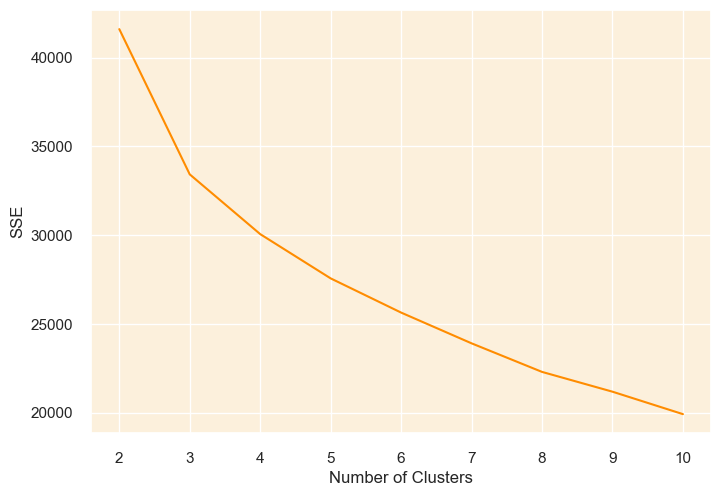

In [36]:
#kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}


sse = [] #sum of squared error list
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### It is observed that there is a strong bend at 3.

### Alternate Library for elbow method

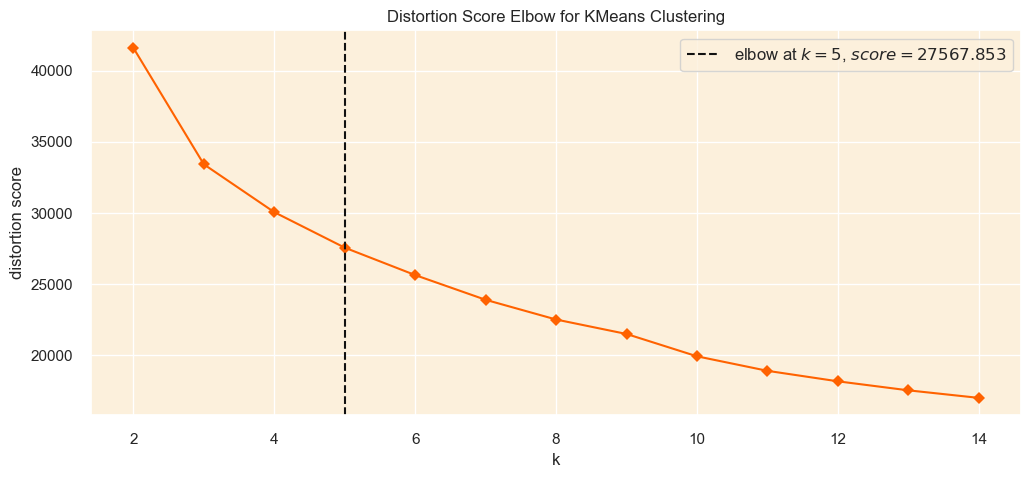

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(df)

# Finalize and render the figure
visualizer.show()

In [38]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

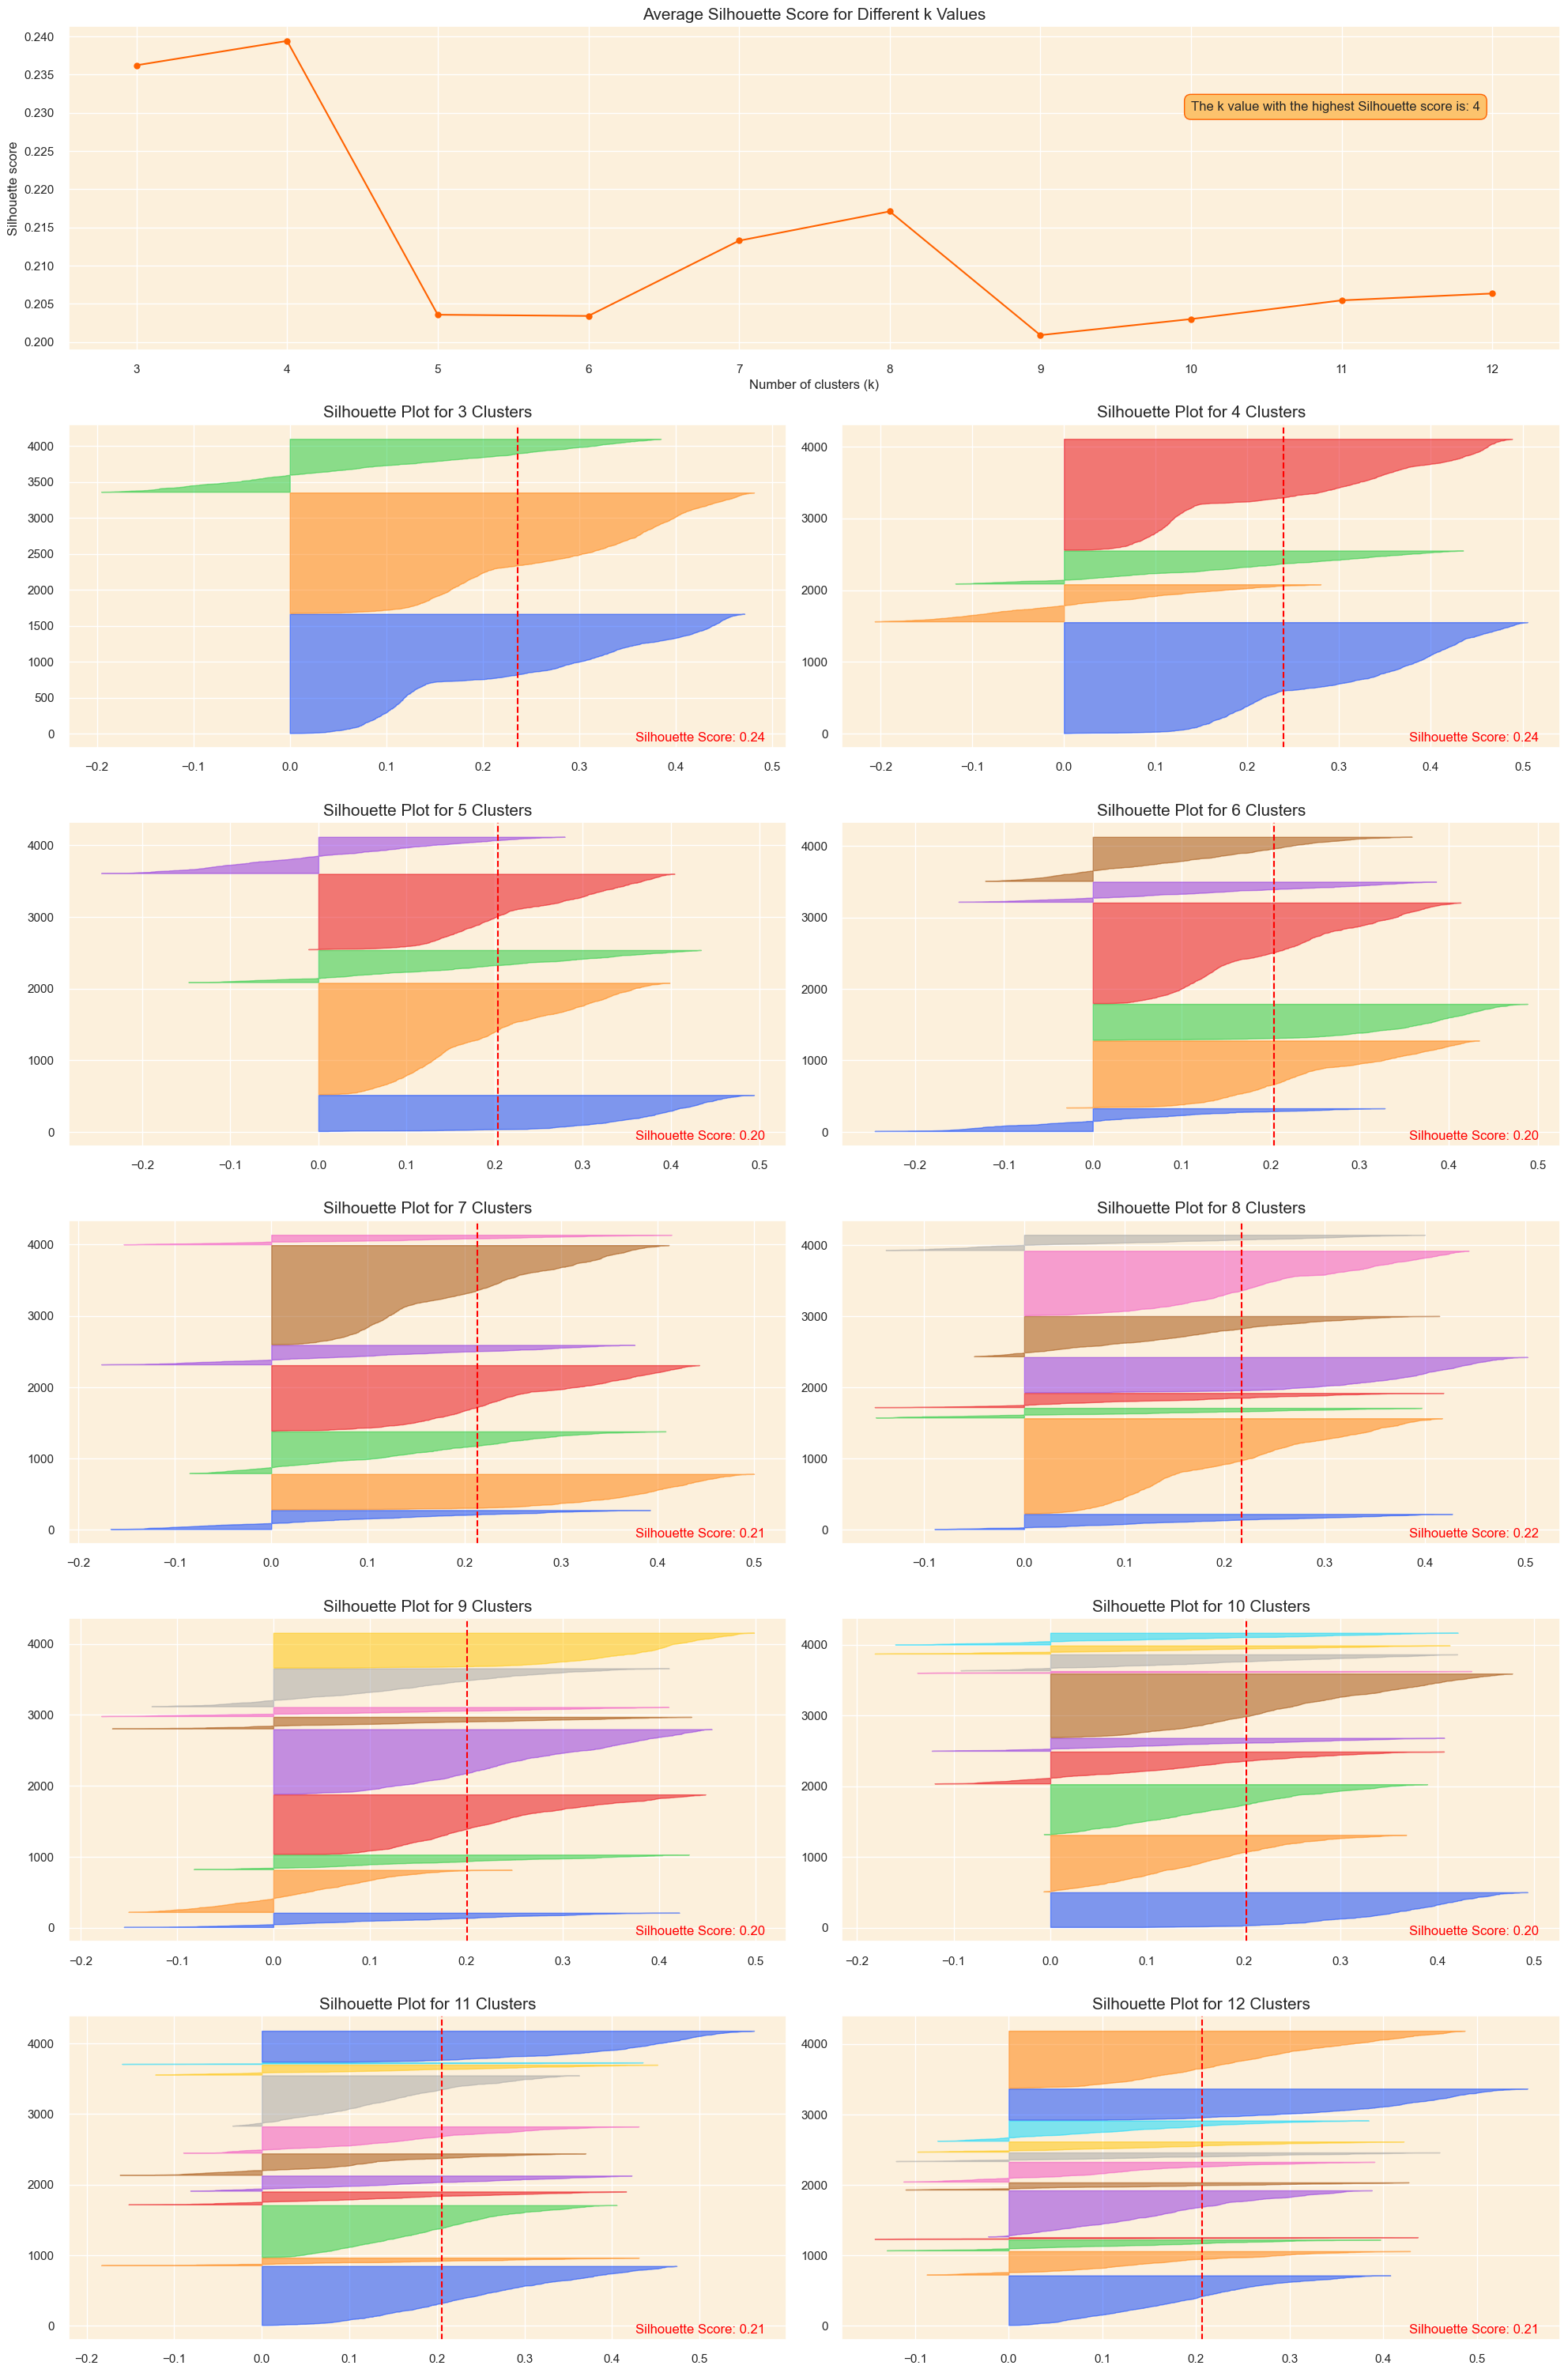

In [39]:
silhouette_analysis(df, 3, 12, figsize=(20, 50))

In [40]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(df)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_) 

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
cleaned['cluster'] = new_labels

# Append the new cluster labels to the DataFrame 
df['cluster'] = new_labels 

In [41]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
0,-2.186469,-1.705370,-1.576745,-1.008187,-0.411803,-1.658012,2
1,3.290264,-1.387375,1.923310,0.930990,-0.010591,0.873150,0
2,0.584684,0.585019,0.664727,0.655411,-0.470280,2.306657,1
3,1.791116,-2.695652,5.850040,-0.853418,0.677111,-1.520098,2
4,-1.997139,-0.542639,0.578781,-0.183682,-1.484838,0.062672,2


In [42]:
# # 3D Visualization 
colors = ['#e41a1c', '#377eb8', '#4daf4a'] 

cluster_0 = df[df['cluster'] == 0]
cluster_1 = df[df['cluster'] == 1]
cluster_2 = df[df['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()




C:\Users\anish\AppData\Local\Temp\ipykernel_8424\4189075999.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




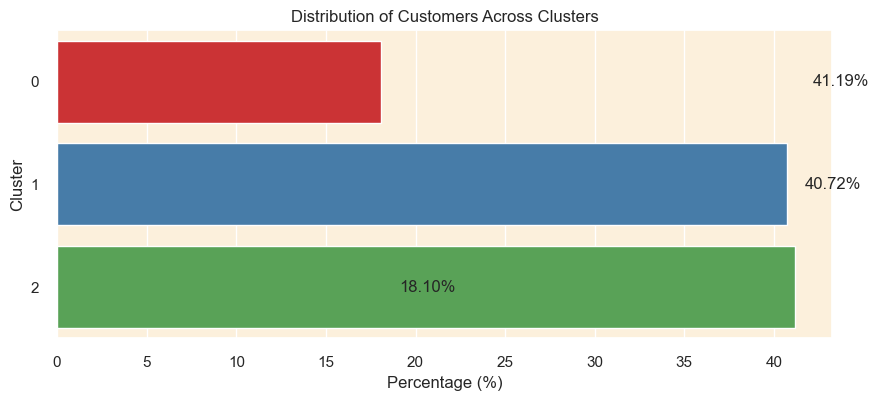

In [43]:
# Cluster Distribution Bar Plot
cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
for i, v in enumerate(cluster_percentage['Percentage']):
    plt.text(v + 1, i, f'{v:.2f}%', va='center')

plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Percentage (%)')
plt.show()

### Insights Derived

In [44]:
# Perform ANOVA F-test
f_values, p_values = f_classif(df.drop('cluster', axis=1), df['cluster'])

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': df.columns[:-1], 'F-value': f_values, 'p-value': p_values})

# Sort by F-value in descending order
feature_importance = feature_importance.sort_values('F-value', ascending=False)

print(feature_importance)

  Feature      F-value       p-value
0     PC1  3715.596866  0.000000e+00
1     PC2  3124.091872  0.000000e+00
2     PC3    15.780555  1.489590e-07
4     PC5     4.687752  9.257203e-03
3     PC4     4.638273  9.725660e-03
5     PC6     3.985025  1.866467e-02


#### This output ranks the features based on their importance in differentiating between clusters. Higher F-values indicate features that are more strongly associated with cluster membership.

In [45]:
cluster_profiles = cleaned.groupby('cluster').describe()
print(cluster_profiles)

        Unnamed: 0                                                           \
             count         mean          std  min      25%     50%      75%   
cluster                                                                       
0            736.0  1959.885870  1183.116791  1.0   963.50  1903.5  2999.25   
1           1656.0  2022.209541  1161.322884  2.0  1002.75  1991.0  3013.75   
2           1675.0  2075.794627  1181.744477  0.0  1067.50  2111.0  3096.50   

                CustomerID                ... Monthly_Spending_Std  \
            max      count          mean  ...                  75%   
cluster                                   ...                        
0        4065.0      736.0  15211.111413  ...           442.723596   
1        4064.0     1656.0  15302.159420  ...           118.147897   
2        4066.0     1675.0  15379.645970  ...           113.428366   

                     Spending_Trend                                  \
                 max          cou

#### This output provides descriptive statistics for each feature within each cluster and in essence, profiles individual clusters.

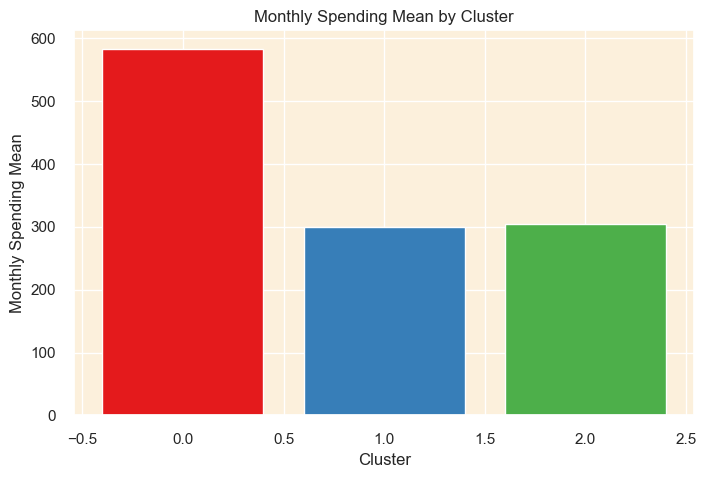

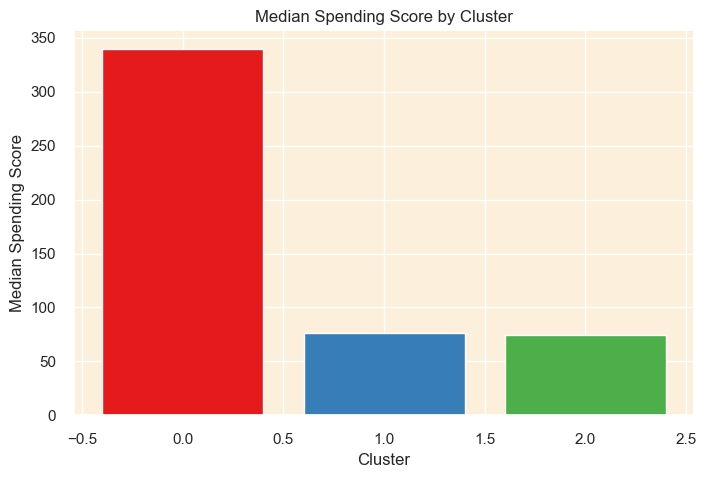

In [46]:
# Calculate mean and median values for each cluster
monthly_spending_mean = cleaned.groupby('cluster')['Monthly_Spending_Mean'].mean()
median_spending_score = cleaned.groupby('cluster')['Monthly_Spending_Std'].mean()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Cluster': monthly_spending_mean.index,
    'Monthly Spending Mean': monthly_spending_mean.values,
    'Median Spending Score': median_spending_score.values
})

plt.figure(figsize=(8, 5))
plt.bar(plot_data['Cluster'], plot_data['Monthly Spending Mean'], color=['#e41a1c', '#377eb8', '#4daf4a'])
plt.xlabel('Cluster')
plt.ylabel('Monthly Spending Mean')
plt.title('Monthly Spending Mean by Cluster')
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(plot_data['Cluster'], plot_data['Median Spending Score'], color=['#e41a1c', '#377eb8', '#4daf4a'])
plt.xlabel('Cluster')
plt.ylabel('Median Spending Score')
plt.title('Median Spending Score by Cluster')
plt.show()

We can observe that the first cluster has a much higher mean and median value rate than the other two clusters.

## Mean Display per feature


['Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Products_Purchased', 'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased', 'Average_Days_Between_Purchases', 'Day_Of_Week', 'Hour', 'Is_UK', 'Cancellation_Frequency', 'Cancellation_Rate', 'Monthly_Spending_Mean', 'Monthly_Spending_Std', 'Spending_Trend']


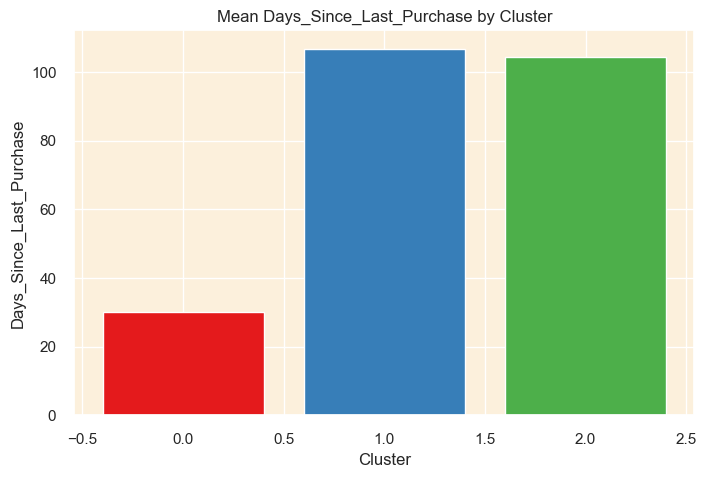

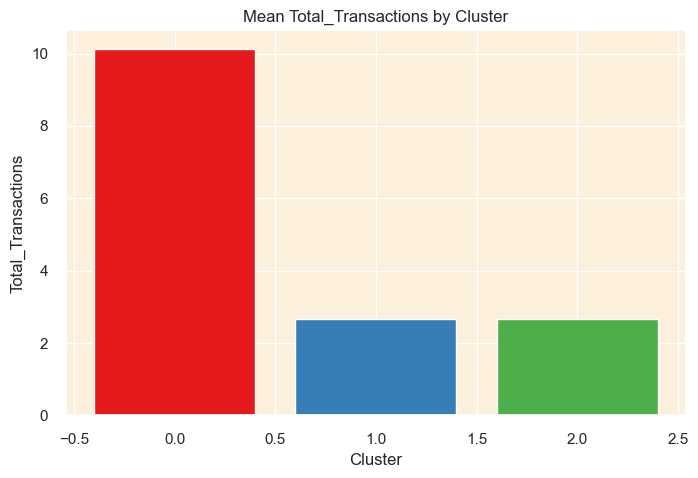

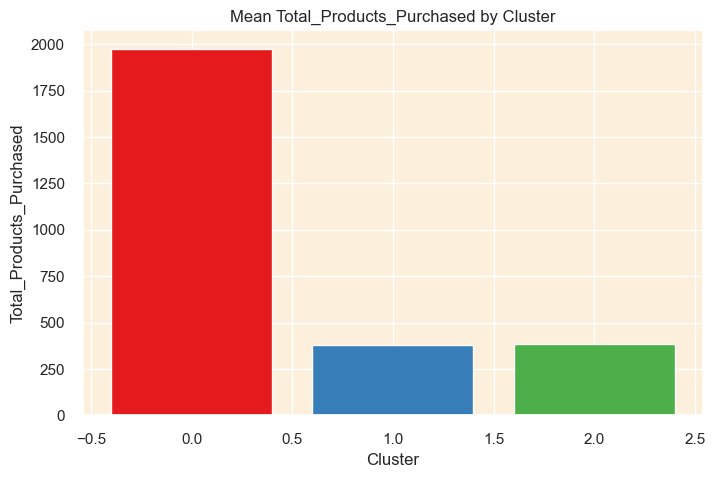

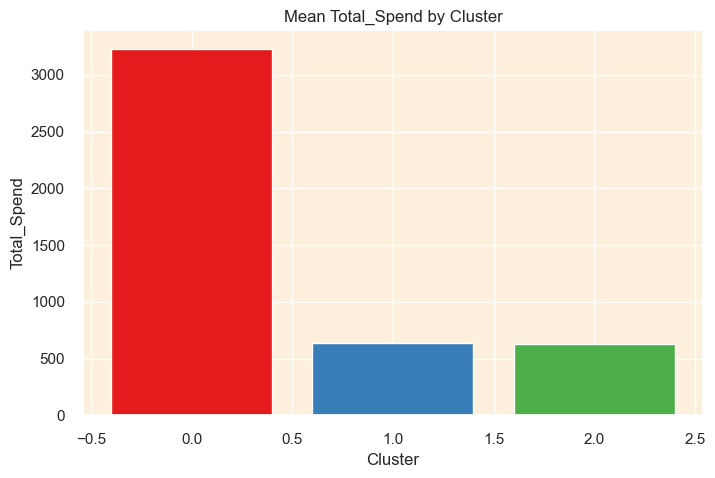

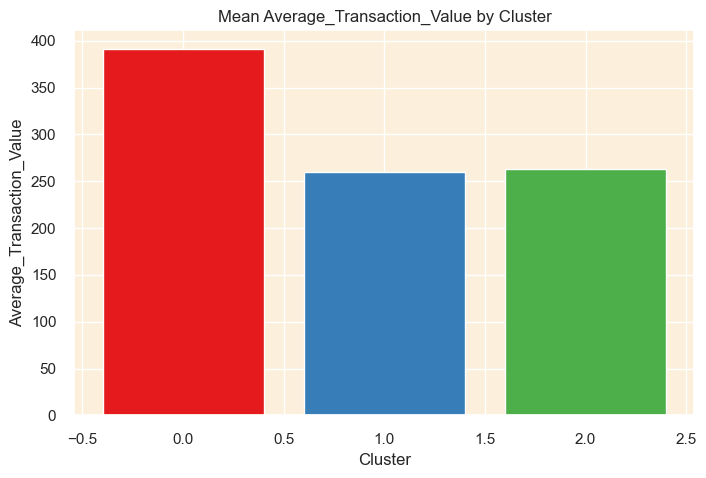

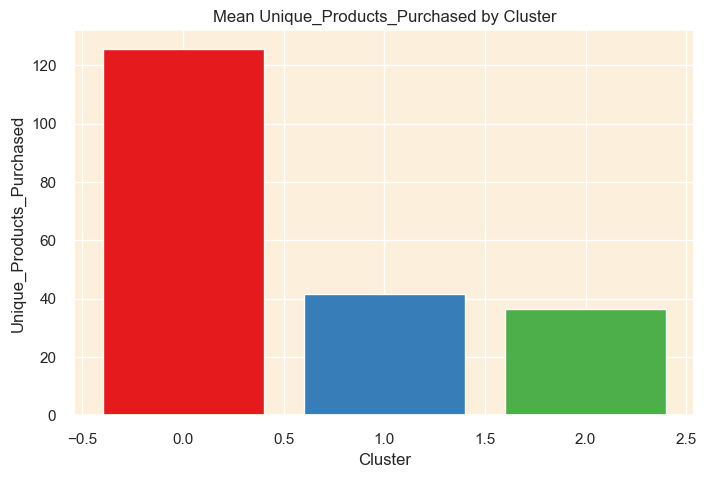

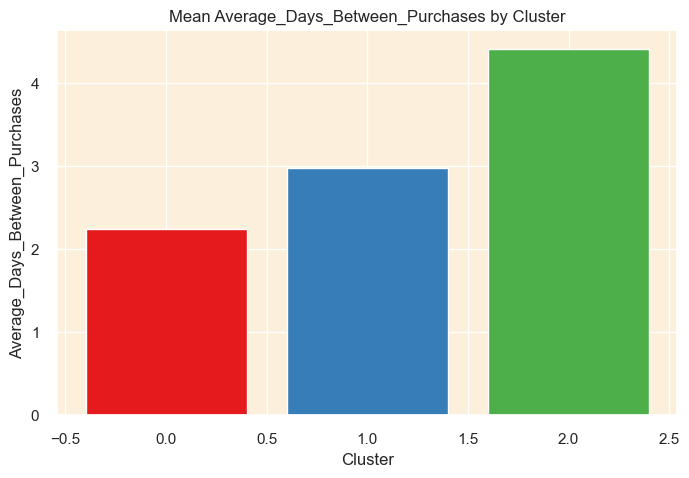

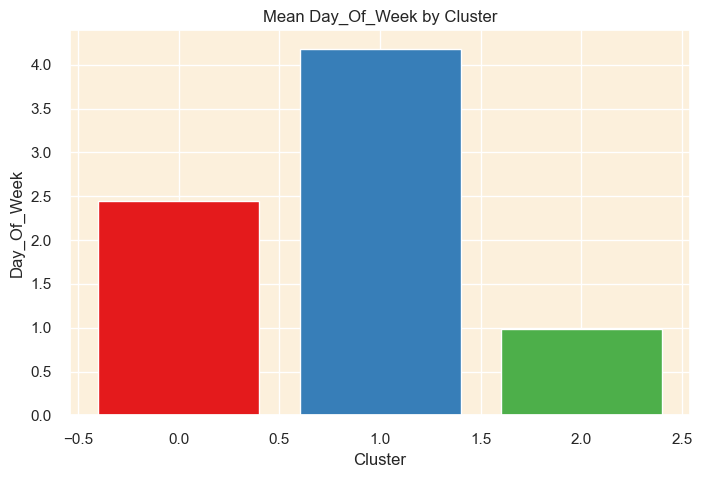

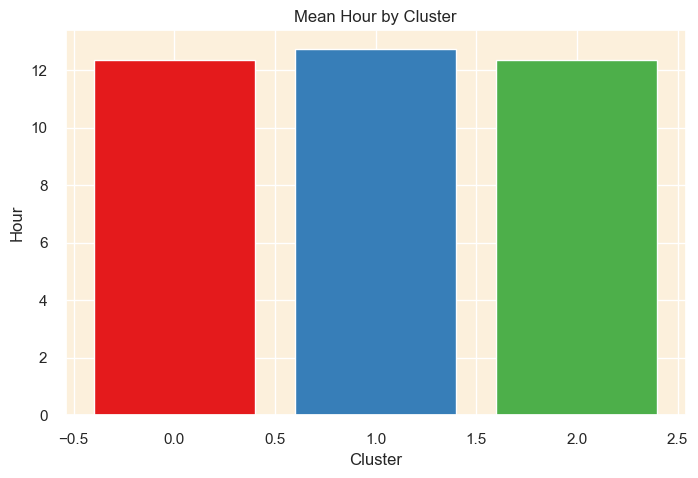

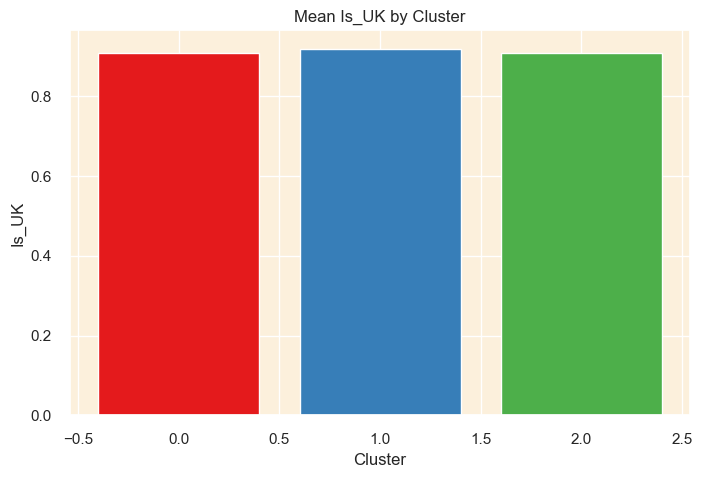

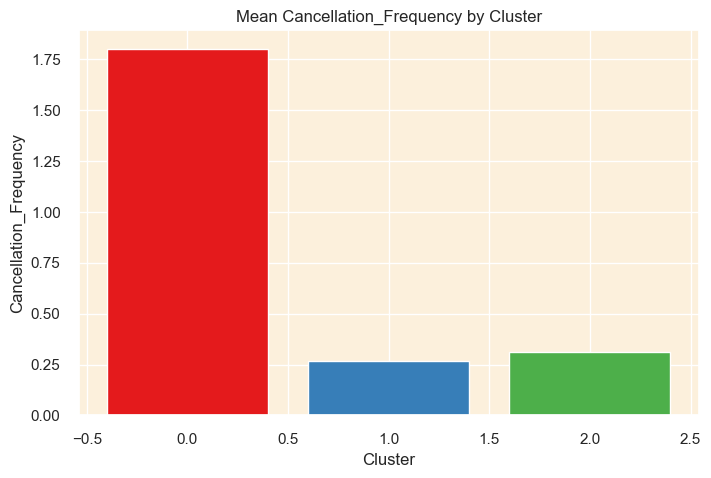

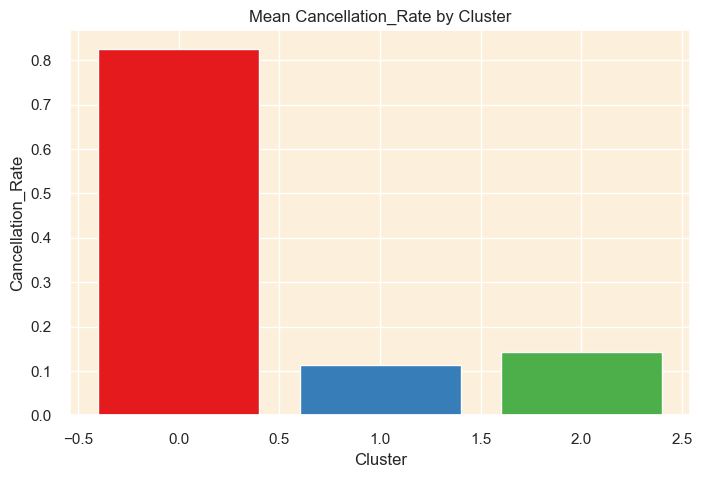

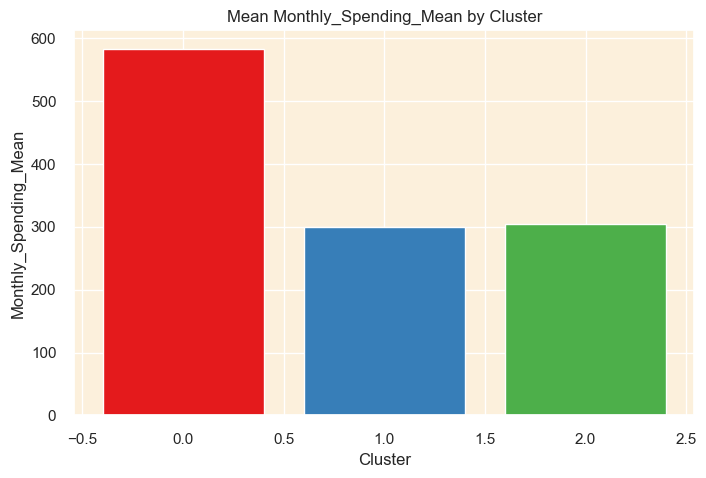

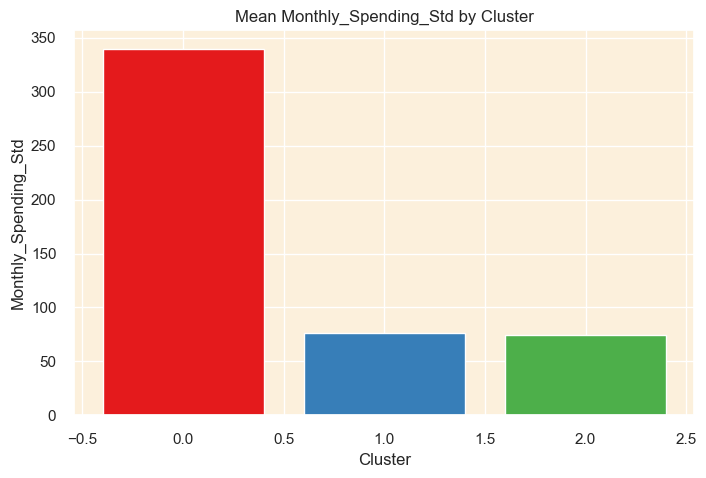

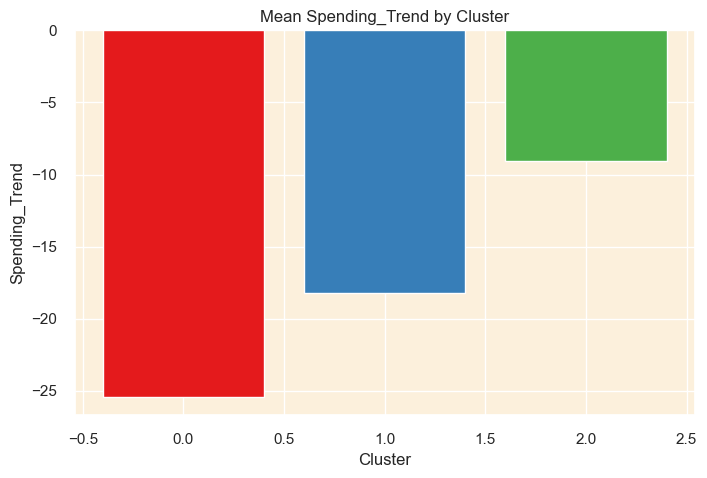

In [47]:
features = cleaned.columns.tolist()
features.remove('cluster')
features.remove('Unnamed: 0')
features.remove('CustomerID')


print(features)

cluster_means = cleaned.groupby('cluster')[features].mean()

for feature in features:
    plt.figure(figsize=(8, 5))
    plt.bar(cluster_means.index, cluster_means[feature], color=colors)
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.title(f'Mean {feature} by Cluster')
    plt.show()

## Cluster Profiling by Radar Chart Analysis

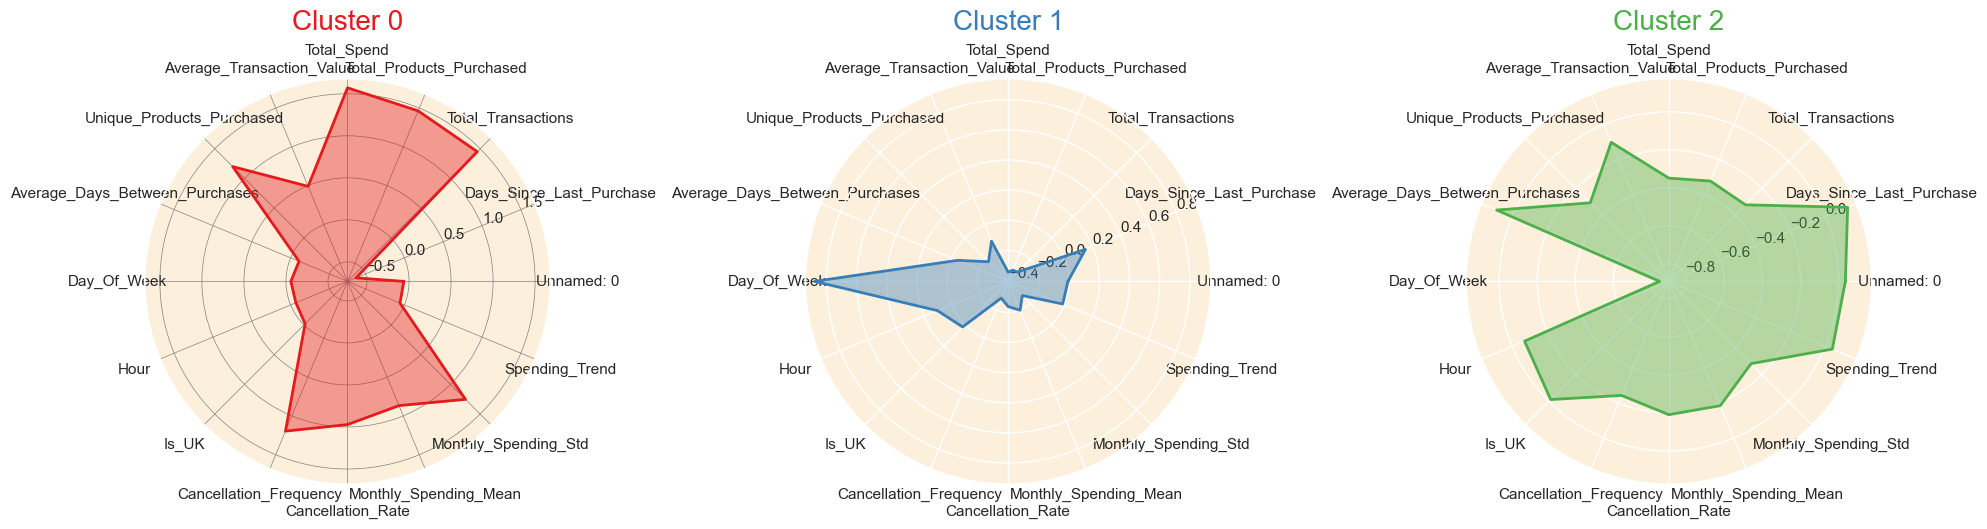

In [48]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

### Cluster 0 (Red)

#### High Spenders
This cluster stands out with the highest Total Spend, Average Transaction Value, Total Transactions, and Monthly Spending Mean. They likely represent the most valuable customers.
#### Frequent Buyers
They also have a high number of Unique Products Purchased, indicating a broader interest in distinct products.
#### Active & Engaged
The relatively low Average Days Between Purchases and Days Since Last Purchase suggest that these customers shop frequently.
#### Higher Cancellation Frequency
This cluster has a noticeably higher Cancellation Frequency than the others.



### Cluster 1 (Blue)

#### Low Spenders
This cluster shows the lowest levels of Total Spend, Average Transaction Value, and Monthly Spending Mean. Customers in this cluster likely only buy out of necessity. They may also represent less engaged or price-sensitive customers.
#### Negligible Interest in Variety
Compared to the other clusters, they have fewer Total Transactions and Unique Products Purchased, suggesting less frequent purchases and a fixed narrow product interest.
#### High Engagement
Low Average Days Between Purchases and Days Since Last Purchase indicate frequent shopping behavior like Cluster 0.
#### Low Cancellation Frequency
This cluster has a low cancellation frequency potentially indicationg the customers are generally satisfied with their purchases. Although they don't spend much, they don't cancel often.


### Cluster 2 (Green)

#### Moderate Spenders
This cluster exhibits moderate values across most spending metrics, including Total Spend, Average Transaction Value, Total Transactions, and Monthly Spending Mean. These customers are placed between the customers of Cluster 0 and Cluster 1.
#### Average Product Interest
Moderate Unique Products Purchased suggests an interest in some products or categories.
#### Infrequent Buyers
The high Average Days Between Purchases and Days Since Last Purchase indicate infrequent shopping behavior.
#### Medium Cancellation Frequency
The customers cancel in a moderate amount.
